In [1]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from pytesseract import*

from fuzzywuzzy import fuzz

from sklearn.utils import shuffle

from util import randomChoice, lineToTensor, readFile

import xml.etree.ElementTree as ET 
import re

# other libraries required by this notebook
import string
import time
import math
import random
import glob
import os

# the number of hidden neurons of the RNN
n_hidden = 128*4

# a list containing all ascii caracters and some german exclusive ones
all_letters = string.ascii_letters + " .,;'" + "äÄüÜöÖß"
n_letters = len(all_letters)

device = torch.device("cuda")

(4032, 3024, 3)


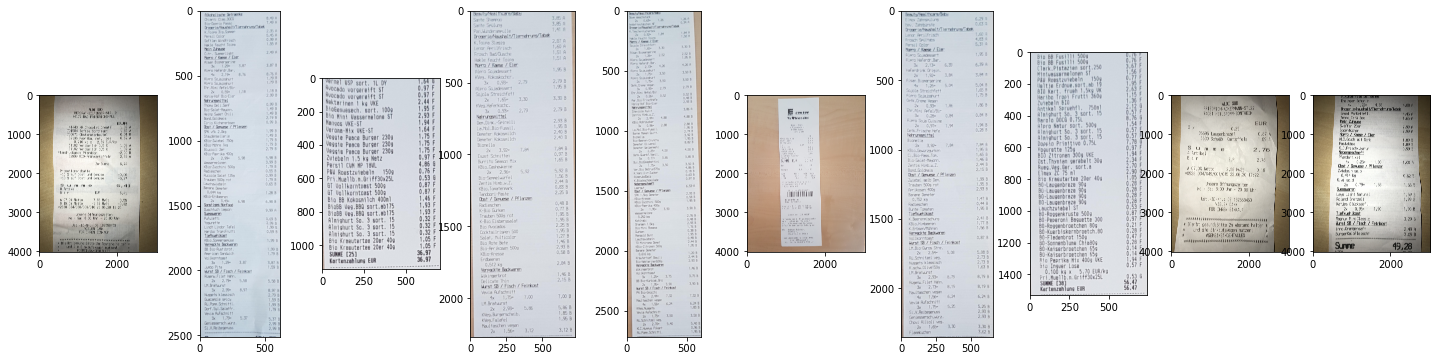

In [2]:
images = []
bboxes = []
figNo = 1
fig=plt.figure(figsize=(30, 6))
for i in range(1,11):
    bbox = []
    tree = ET.parse("data/receipts/" + str(i) + ".xml")
    root = tree.getroot()
    for item in root.findall('.//object'):
        x0 = int(item.find('bndbox').find('xmin').text)
        x1 = int(item.find('bndbox').find('xmax').text)
        y0 = int(item.find('bndbox').find('ymin').text)
        y1 = int(item.find('bndbox').find('ymax').text)
        bbox.append([y0,x0,y1,x1])
    img0 = cv2.imread("data/receipts/" + str(i) + ".jpg")
    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    images.append(img0)
    fig.add_subplot(1, 12, figNo) 
    plt.imshow(img0)
    figNo +=1
    bboxes.append(bbox)
    
print(img0.shape)
plt.show()

(4032, 3024, 3)


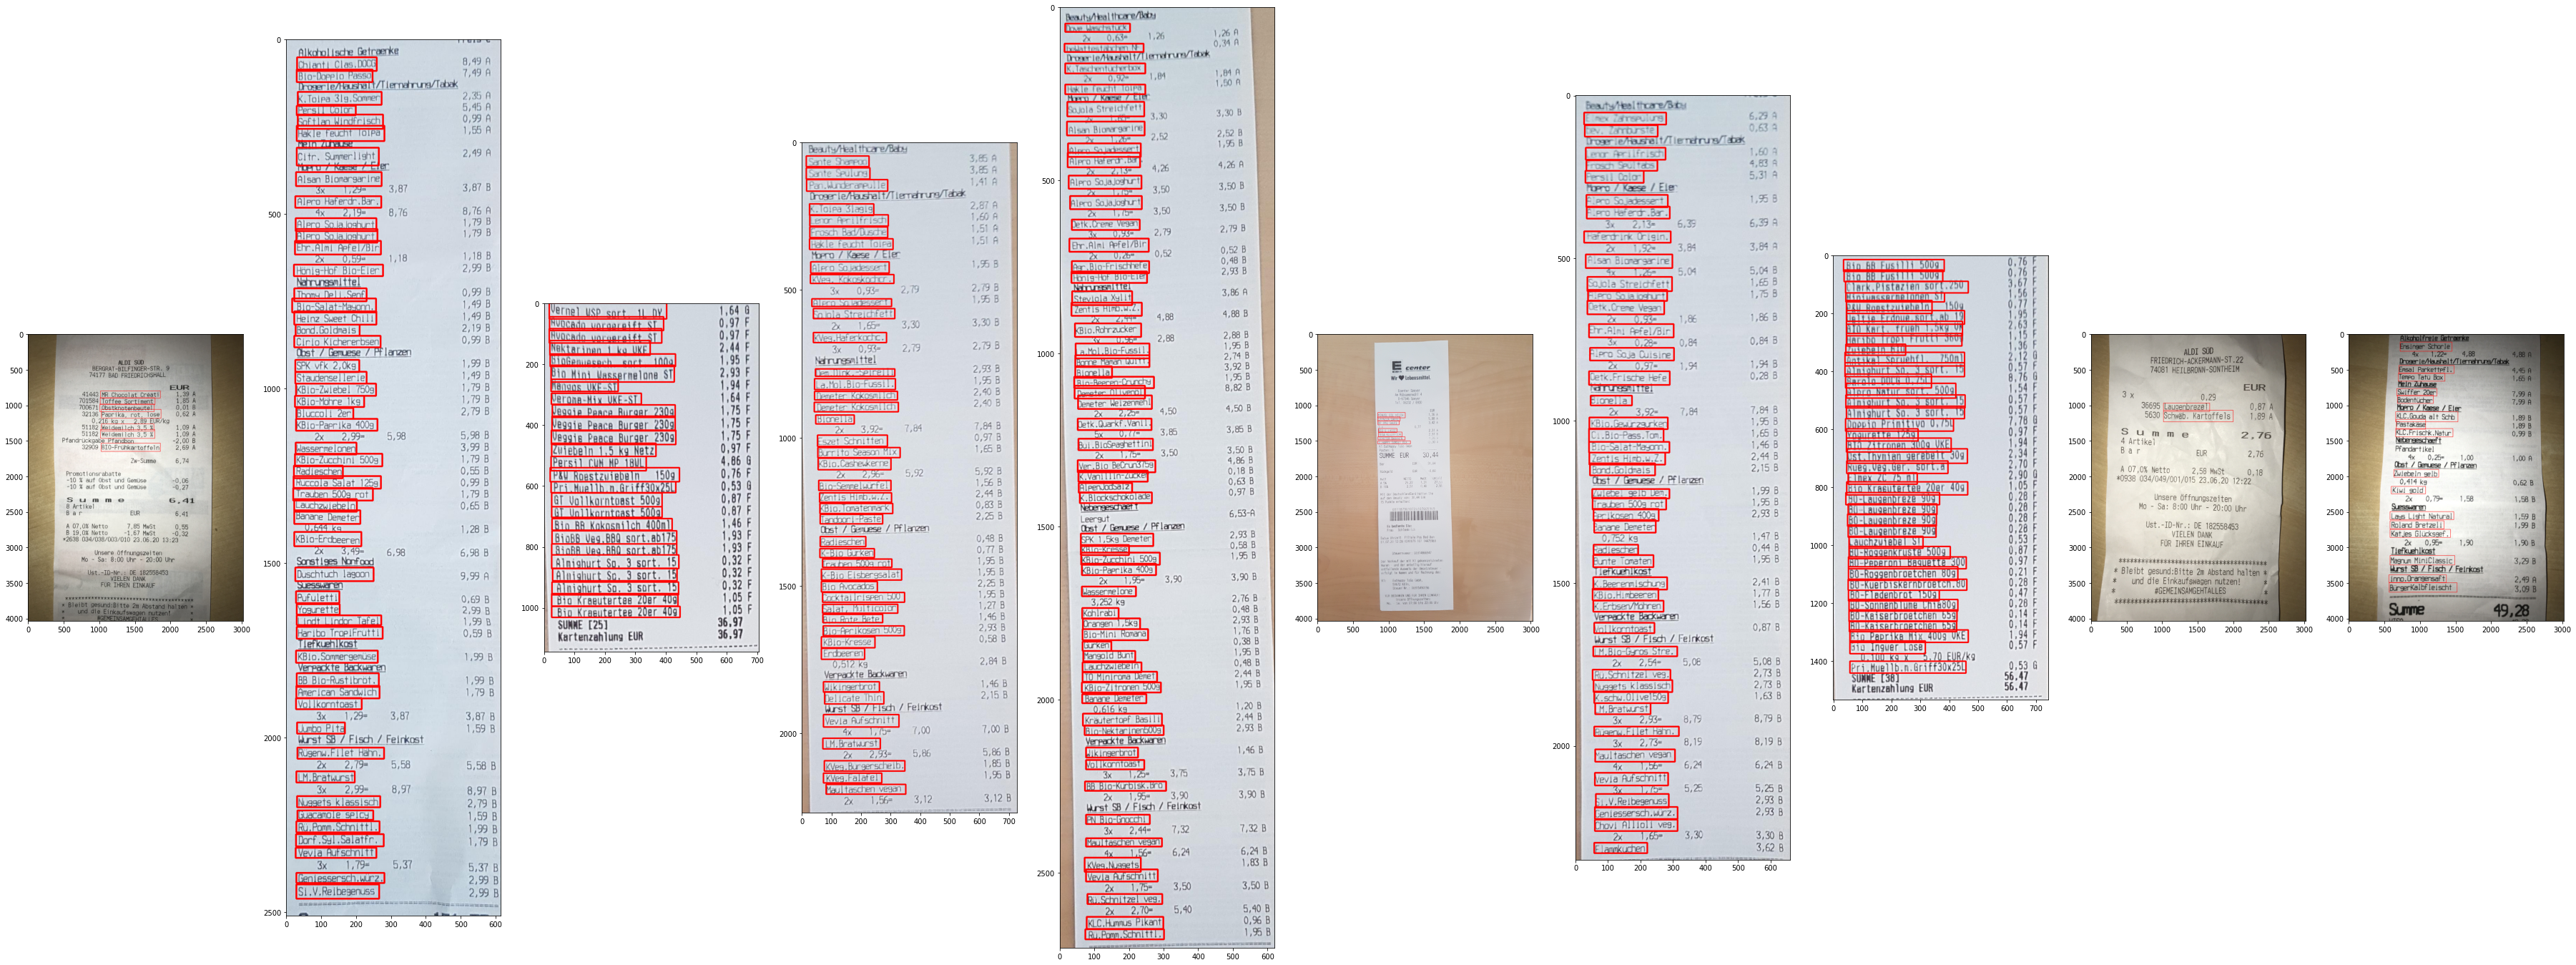

In [3]:
figNo = 1
fig=plt.figure(figsize=(70, 40))
for i, image in enumerate(images):
    img_clone = np.copy(image)
    bbox_clone = bboxes[i]
    #print(bbox_clone)
    for i in range(len(bboxes[i])):
        cv2.rectangle(img_clone, (bbox_clone[i][1], bbox_clone[i][0]), (bbox_clone[i][3], bbox_clone[i][2]), color=(255,0,0), thickness=3)
        
    fig.add_subplot(1, 11, figNo) 
    plt.imshow(img_clone)
    figNo +=1
    
print(img0.shape)
plt.show()

In [4]:
# the Keyword Context Network
class KCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(KCN, self).__init__()
    
        self.hidden_size = hidden_size

        self.i2h1 = nn.Linear(input_size + hidden_size, 2*(input_size + hidden_size))
        self.i2h2 = nn.Linear(2*(input_size + hidden_size), hidden_size)
        self.i2o1 = nn.Linear(input_size + hidden_size, 2*(input_size + hidden_size))
        self.i2o2 = nn.Linear(2*(input_size + hidden_size), 2*(input_size + hidden_size))
        self.i2o3 = nn.Linear(2*(input_size + hidden_size), output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h1(combined)
        hidden = self.i2h2(hidden)
        output = self.i2o1(combined)
        output = self.i2o2(output)
        output = self.i2o3(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [5]:
# the ocr component build using tesseract
class OCR(object):
    def __init__(self, language):
        super(OCR, self).__init__()
        
        self.language = language
    
    def getString(self, image, boundingBox=[]):
        if not len(boundingBox):
            return pytesseract.image_to_string(image,lang=self.language)
        y0, x0, y1, x1 = np.array(boundingBox)
        h = y1-y0
        w = x1-x0
        res = image[y0:y0+h,x0:x0+w]
        return pytesseract.image_to_string(res,lang=self.language)
    
    def getDict(self, image):
        return pytesseract.image_to_data(image, output_type=Output.DICT) 
    
    def getTrainingData(self, image, bbox):
        ocrWhole = self.getString(image)
        regex1 = re.compile('[^a-zA-ZäÄüÜöÖ\n]')
        ocrWhole = regex1.sub('', ocrWhole).upper()
        ocrWhole = ocrWhole.split("\n")
        
        ocrBbox = []
        regex2 = re.compile('[^a-zA-ZäÄüÜöÖ]')
        for i in range(len(bbox)):
            s = self.getString(image, bbox[i])
            res = regex2.sub('', s).upper()
            ocrBbox.append(res)
            
        for word1 in ocrBbox:
            for word2 in ocrWhole:
                distance = fuzz.ratio(word1, word2)
                if distance > 60 and word1 and word2:
                    ocrWhole.remove(word2)
                    
        while("" in ocrWhole) : 
            ocrWhole.remove("") 
    
        while("" in ocrBbox) : 
            ocrBbox.remove("") 
            
        return ocrWhole, ocrBbox

In [6]:
ocr = OCR("deu")

In [7]:
training_data = []
for i in range(len(images)):
    print(i,len(images), end="\r")
    ocrWhole, ocrBbox = ocr.getTrainingData(images[i], bboxes[i])
    training_data.append([ocrBbox, ocrWhole])

In [31]:
kcn = KCN(n_letters, n_hidden, 2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(kcn.parameters(), 0.003)

writer = SummaryWriter()

In [9]:
x = [[],[]]
categories = [0,1]

In [10]:
for data in training_data:
    for line in data[0]:
        x[0].append(line)
    for line in data[1]:
        x[1].append(line)
for product in readFile("../webapp/allproducts.txt"):
    x[0].append(product)

In [20]:
# returns the prediction of the network by passing every letterTensor through the network
def evaluate(line_tensor):
    hidden = kcn.initHidden().to(device) # initialize a hidden tensor for the first feed
    
    # pass every letter tensor through the network
    for i in range(line_tensor.size()[0]):
        output, hidden = kcn(line_tensor[i], hidden)

    return output

In [12]:
# returns a random training example
def randomTrainingExample():
    category = randomChoice(categories)
    line = randomChoice(x[category])
    category_tensor = torch.tensor([category], dtype=torch.long).to(device)

    line_tensor = lineToTensor(line).to(device)
    return category, line, category_tensor, line_tensor

In [13]:
# retieves the category of an output by the network
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return categories[category_i], category_i

In [14]:
# performs a training step with the given line and category tensor
def train(category_tensor, line_tensor):
    
    hidden = kcn.initHidden().to(device) # initialize a hidden tensor for the first feed

    optimizer.zero_grad() # reset the current gradients 
    
    # pass every letter tensor through the network
    for i in range(line_tensor.size()[0]):
        output, hidden = kcn(line_tensor[i], hidden)
    
    # define our loss criterion
    loss = criterion(output, category_tensor)
    loss.backward()

   
    # Add parameters gradients to their values, multiplied by learning rate (Gradient Descent)
    optimizer.step()

    return output, loss.item()

In [15]:
all_losses = []

5000 16% (0m 19s) 0.5205 KBEEREMMISCHUNG / 0 ✓
10000 33% (0m 38s) 0.7661 MTABEETEEBTEEENFENPTDWPAPRIKAROTLOSE / 1 ✗ (0)
15000 50% (0m 57s) 0.1134 OOUMWUNMO / 1 ✓
20000 66% (1m 15s) 0.0282 ZAFNBURSTE / 0 ✓
25000 83% (1m 33s) 0.0601 ZUCKERMELONE / 0 ✓
30000 100% (1m 53s) 0.1234 VEVIAAUFSCHNITT / 0 ✓


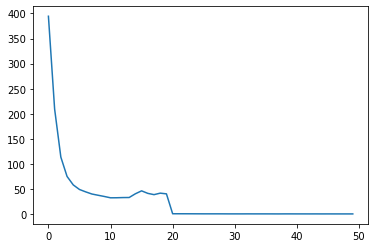

In [32]:
n_iters = 30000
print_every = 5000
plot_every = 1000

current_loss = 0


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        writer.add_scalar('Loss/train', current_loss / plot_every, iter)
        current_loss = 0

# plot the graph of the losses returned during training
plt.figure()
plt.plot(all_losses)

In [33]:
#kcn.load_state_dict(torch.load("kcn.pth"))
kcn.eval()

KCN(
  (i2h1): Linear(in_features=576, out_features=1152, bias=True)
  (i2h2): Linear(in_features=1152, out_features=512, bias=True)
  (i2o1): Linear(in_features=576, out_features=1152, bias=True)
  (i2o2): Linear(in_features=1152, out_features=1152, bias=True)
  (i2o3): Linear(in_features=1152, out_features=2, bias=True)
)

In [34]:
def predict(input_line, n_predictions=2):
        #print('\n> %s' % input_line)
        with torch.no_grad():
            output = evaluate(lineToTensor(input_line).to(device))

            # Get top N categories
            topv, topi = F.softmax(output, dim=1).topk(n_predictions, 1, True)
            predictions = []

            for i in range(n_predictions):
                value = topv[0][i].item()
                category_index = topi[0][i].item()
                #print('(%.2f) %s' % (value, categories[category_index]))
                predictions.append([value, categories[category_index]])
        return predictions

In [66]:
torch.save(kcn.state_dict(), "kcn.pth")

In [63]:
ocrWhole, ocrBbox = ocr.getTrainingData(images[0], bboxes[0])
ocrBbox

['MRCHOCOLATCREAT',
 'LOFFEESORTIMENT',
 'OBSTKRIOTERIBEUTEL',
 'MTABEETEEBTEEENFENPTDWPAPRIKAROTLOSE',
 'WEIDEMILCH',
 'EEEERULTEWATWEIDEMIICH',
 'BIOFRÜHKARTOFFELN']

In [64]:
for string in ocrBbox:
    pred = predict(string.upper())
    if pred[0][1] == 0:
        print(string, pred[0][0], '✓')
    else:
        print(string, pred[1][0], "✗")

MRCHOCOLATCREAT 0.9837309122085571 ✓
LOFFEESORTIMENT 0.978995144367218 ✓
OBSTKRIOTERIBEUTEL 0.8641700744628906 ✓
MTABEETEEBTEEENFENPTDWPAPRIKAROTLOSE 0.502866804599762 ✓
WEIDEMILCH 0.983693540096283 ✓
EEEERULTEWATWEIDEMIICH 0.9879839420318604 ✓
BIOFRÜHKARTOFFELN 0.996654748916626 ✓


In [65]:
for string in ocrWhole:
    pred = predict(string.upper())
    if pred[0][1] == 0:
        print(string, pred[0][0], '✓')
    else:
        print(string, pred[1][0], "✗")

AALDI 0.24237589538097382 ✗
BERGRATETEFTÄGERSTRER 0.2656731605529785 ✗
BADFRIEDRICHSHALL 0.9440533518791199 ✓
M 0.07947126030921936 ✗
E 0.20189979672431946 ✗
PAPRIKAROTLOSE 0.5355666875839233 ✓
KGXEURKG 0.1104666218161583 ✗
PFANDRÜCKGABEPFANDBON 0.38475337624549866 ✗
KO 0.009922444820404053 ✗
OORH 0.10898080468177795 ✗
NN 0.03508520498871803 ✗
OONDRAON 0.29830771684646606 ✗
POPMM 0.21654923260211945 ✗
SA 0.0032859237398952246 ✗
I 0.2527066767215729 ✗
CNNDANEH 0.5446677207946777 ✓
WSUMME 0.41230159997940063 ✗
PROMOTIONSRABATTE 0.585015594959259 ✓
AUFOBSTUNDGEMÜSE 0.12826399505138397 ✗
AUFOBSTUNDGEMÜSE 0.12826399505138397 ✗
NETTOMWST 0.3211556375026703 ✗
NETTOMWST 0.3211556375026703 ✗
UNSEREÖFFNUNGSZEITEN 0.16907274723052979 ✗
MOSAUHRUHR 0.21530835330486298 ✗
UTAHEISSDE 0.976929783821106 ✓
UWELLENDANK 0.31438329815864563 ✗
FÜRIHRENVEN 0.8587496280670166 ✓
